# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from datetime import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from pyfinance.ols import PandasRollingOLS
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load US equity OHLCV data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [4]:
DATA_STORE = '../data/assets.h5'

In [5]:
YEAR = 12

In [6]:
START = 1995
END = 2017

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], :]
              .filter(like='adj_')
              .dropna()
              .swaplevel()
              .rename(columns=lambda x: x.replace('adj_', ''))
              .join(store['us_equities/stocks']
                    .loc[:, ['sector']])
              .dropna())

In [8]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10241831 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   open    10241831 non-null  float64
 1   high    10241831 non-null  float64
 2   low     10241831 non-null  float64
 3   close   10241831 non-null  float64
 4   volume  10241831 non-null  float64
 5   sector  10241831 non-null  object 
dtypes: float64(5), object(1)
memory usage: 508.0+ MB


In [9]:
len(prices.index.unique('ticker'))

2369

## Remove stocks with less than ten years of data

In [10]:
min_obs = 10 * 252
nobs = prices.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
prices = prices.drop(to_drop, level='ticker')

In [11]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    9532628 non-null  float64
 1   high    9532628 non-null  float64
 2   low     9532628 non-null  float64
 3   close   9532628 non-null  float64
 4   volume  9532628 non-null  float64
 5   sector  9532628 non-null  object 
dtypes: float64(5), object(1)
memory usage: 472.9+ MB


In [12]:
len(prices.index.unique('ticker'))

1883

## Add some Basic Factors

### Compute the Relative Strength Index

In [13]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

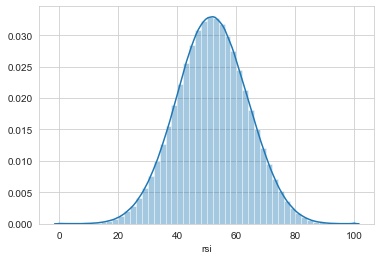

In [14]:
sns.distplot(prices.rsi);

### Compute Bollinger Bands

In [15]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [16]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [17]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   open     9532628 non-null  float64
 1   high     9532628 non-null  float64
 2   low      9532628 non-null  float64
 3   close    9532628 non-null  float64
 4   volume   9532628 non-null  float64
 5   sector   9532628 non-null  object 
 6   rsi      9506266 non-null  float64
 7   bb_high  9496851 non-null  float64
 8   bb_mid   9496851 non-null  float64
 9   bb_low   9496851 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.1+ GB


In [18]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,9.496851e+06,9.496851e+06,9.496851e+06
mean,2.954140e+00,2.881157e+00,2.808174e+00
std,1.024536e+00,1.026901e+00,1.032999e+00
min,8.933146e-03,8.933146e-03,-1.568426e+00
25%,2.303724e+00,2.226078e+00,2.146471e+00
50%,2.940911e+00,2.868116e+00,2.796484e+00
75%,3.555602e+00,3.487039e+00,3.420498e+00
max,1.376991e+01,1.358056e+01,1.346225e+01


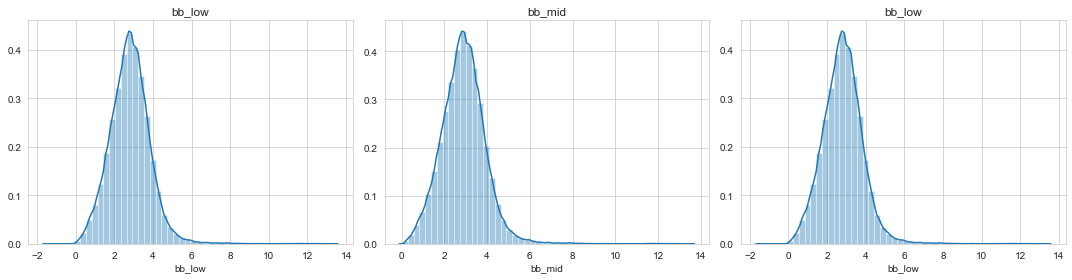

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [20]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close))
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)

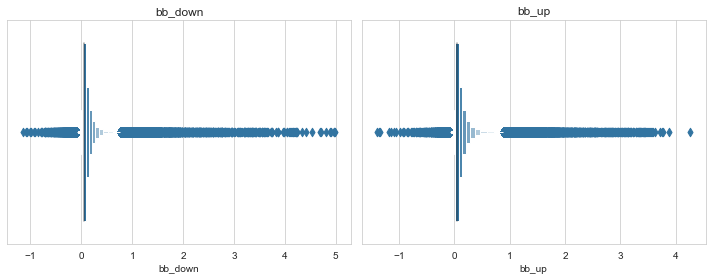

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

### Compute Average True Range

Helper for indicators with multiple inputs:

In [22]:
by_ticker = prices.groupby('ticker', group_keys=False)

In [23]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, 
              stock_data.low, 
              stock_data.close, 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

In [24]:
prices['atr'] = by_ticker.apply(compute_atr)

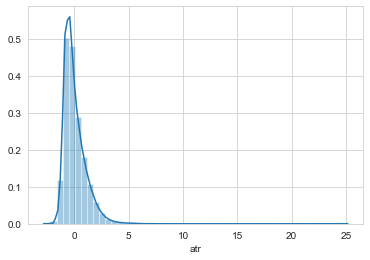

In [25]:
sns.distplot(prices.atr);

In [26]:
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))

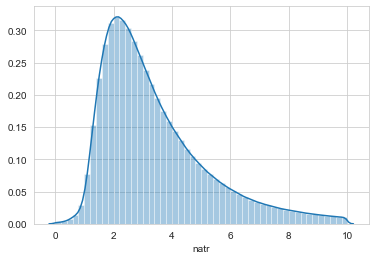

In [27]:
sns.distplot(prices.natr[prices.natr<10]);

### Compute Moving Average Convergence/Divergence

In [28]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = prices.groupby(level='ticker').close.apply(compute_macd)

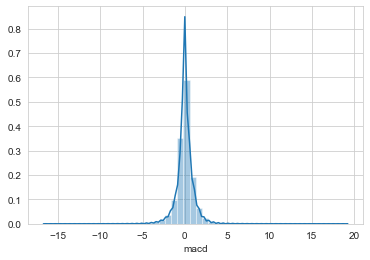

In [29]:
sns.distplot(prices.macd);

## Compute dollar volume to determine universe

In [30]:
prices['dollar_volume'] = (prices.loc[:, 'close']
                           .mul(prices.loc[:, 'volume'], axis=0))

prices.dollar_volume /= 1e6

In [31]:
prices.to_hdf('data.h5', 'us/equities/prices')

In [32]:
prices = pd.read_hdf('data.h5', 'us/equities/prices')
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 16 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           9532628 non-null  float64
 1   high           9532628 non-null  float64
 2   low            9532628 non-null  float64
 3   close          9532628 non-null  float64
 4   volume         9532628 non-null  float64
 5   sector         9532628 non-null  object 
 6   rsi            9506266 non-null  float64
 7   bb_high        9496851 non-null  float64
 8   bb_mid         9496851 non-null  float64
 9   bb_low         9496851 non-null  float64
 10  bb_up          9496851 non-null  float64
 11  bb_down        9496851 non-null  float64
 12  atr            9506266 non-null  float64
 13  natr           9506266 non-null  float64
 14  macd           9470489 non-null  float64
 15  dollar_volume  9532628 no

## Resample OHLCV prices to monthly frequency

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [33]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['dollar_volume', 'volume',
                                                              'open', 'high', 'low']]

In [34]:
prices = prices.unstack('ticker')

In [35]:
data = (pd.concat([prices.dollar_volume.resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   prices[last_cols].resample('M').last().stack('ticker')],
                  axis=1)
        .swaplevel()
        .dropna())

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 452529 entries, ('AAN', Timestamp('1995-02-28 00:00:00')) to ('ZUMZ', Timestamp('2017-12-31 00:00:00'))
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   dollar_volume  452529 non-null  float64
 1   atr            452529 non-null  float64
 2   bb_down        452529 non-null  float64
 3   bb_high        452529 non-null  float64
 4   bb_low         452529 non-null  float64
 5   bb_mid         452529 non-null  float64
 6   bb_up          452529 non-null  float64
 7   close          452529 non-null  float64
 8   macd           452529 non-null  float64
 9   natr           452529 non-null  float64
 10  rsi            452529 non-null  float64
 11  sector         452529 non-null  object 
dtypes: float64(11), object(1)
memory usage: 43.2+ MB


## Select 500 most-traded equities

Select the 500 most-traded stocks based on a 5-year rolling average of dollar volume.

In [37]:
data['dollar_volume'] = (data
                         .groupby('ticker',
                                  group_keys=False,
                                  as_index=False)
                         .dollar_volume
                         .rolling(window=5*12)
                         .mean()
                         .fillna(0)
                         .reset_index(level=0, drop=True))

In [38]:
data['dollar_vol_rank'] = (data
                           .groupby('date')
                           .dollar_volume
                           .rank(ascending=False))

data = data[data.dollar_vol_rank < 500].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 107784 entries, ('AAPL', Timestamp('2000-01-31 00:00:00')) to ('ZION', Timestamp('2017-12-31 00:00:00'))
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   atr      107784 non-null  float64
 1   bb_down  107784 non-null  float64
 2   bb_high  107784 non-null  float64
 3   bb_low   107784 non-null  float64
 4   bb_mid   107784 non-null  float64
 5   bb_up    107784 non-null  float64
 6   close    107784 non-null  float64
 7   macd     107784 non-null  float64
 8   natr     107784 non-null  float64
 9   rsi      107784 non-null  float64
 10  sector   107784 non-null  object 
dtypes: float64(10), object(1)
memory usage: 9.5+ MB


## Create monthly return series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [40]:
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []

In [41]:
for lag in lags:
    returns.append(data
                   .close
                   .unstack('ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 154206 entries, ('AAPL', Timestamp('2000-02-29 00:00:00')) to ('ZIXI', Timestamp('2017-12-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   154206 non-null  float64
 1   return_3m   152522 non-null  float64
 2   return_6m   150006 non-null  float64
 3   return_12m  145000 non-null  float64
dtypes: float64(4)
memory usage: 5.3+ MB


In [42]:
returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,154206.000000,152522.000000,150006.000000,145000.000000
mean,0.007069,0.004762,0.004129,0.003821
std,0.083222,0.048868,0.035565,0.025336
min,-0.264615,-0.173225,-0.130623,-0.089656
25%,-0.016393,-0.006011,-0.002583,-0.000429
50%,0.000000,0.000000,0.000000,0.000000
75%,0.037313,0.025775,0.020045,0.015872
max,0.304386,0.160774,0.113208,0.081740


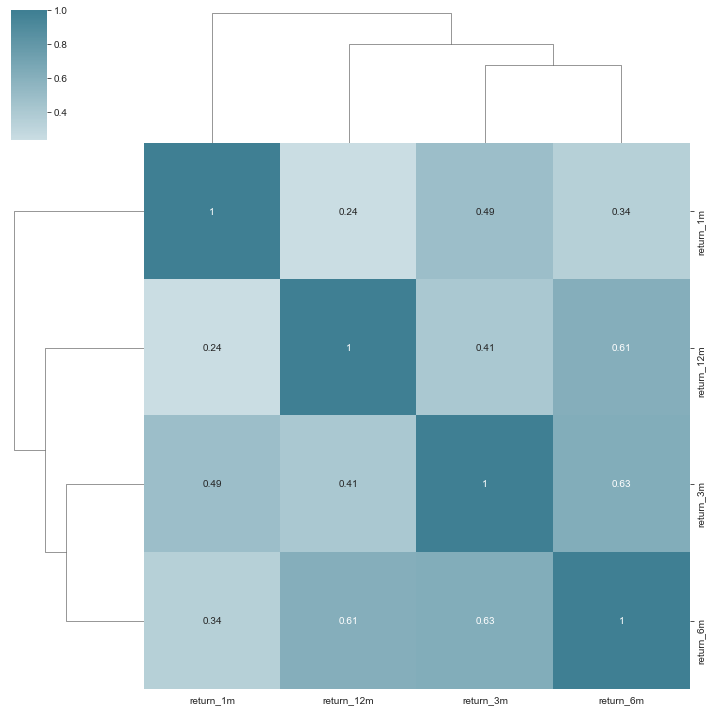

In [43]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [44]:
data = data.join(returns).drop('close', axis=1).dropna()
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 98127 entries, ('AAPL', Timestamp('2001-01-31 00:00:00')) to ('ZION', Timestamp('2017-12-31 00:00:00'))
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atr         98127 non-null  float64
 1   bb_down     98127 non-null  float64
 2   bb_high     98127 non-null  float64
 3   bb_low      98127 non-null  float64
 4   bb_mid      98127 non-null  float64
 5   bb_up       98127 non-null  float64
 6   macd        98127 non-null  float64
 7   natr        98127 non-null  float64
 8   rsi         98127 non-null  float64
 9   sector      98127 non-null  object 
 10  return_1m   98127 non-null  float64
 11  return_3m   98127 non-null  float64
 12  return_6m   98127 non-null  float64
 13  return_12m  98127 non-null  float64
dtypes: float64(13), object(1)
memory usage: 10.9+ MB


In [45]:
min_obs = 5*12
nobs = data.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
data = data.drop(to_drop, level='ticker')

In [46]:
len(data.index.unique('ticker'))

578

We are left with 787 tickers.

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 8, Time Series Models]([](../../08_time_series_models)).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [47]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                             'famafrench', 
                             start=START)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 303 entries, 1995-01-31 to 2020-03-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  303 non-null    float64
 1   SMB     303 non-null    float64
 2   HML     303 non-null    float64
 3   RMW     303 non-null    float64
 4   CMA     303 non-null    float64
dtypes: float64(5)
memory usage: 14.2 KB


In [48]:
factor_data = factor_data.join(data['return_1m']).dropna().sort_index()
factor_data['return_1m'] -= factor_data['Mkt-RF']
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 92011 entries, ('A', Timestamp('2005-12-31 00:00:00', freq='M')) to ('ZION', Timestamp('2017-12-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     92011 non-null  float64
 1   SMB        92011 non-null  float64
 2   HML        92011 non-null  float64
 3   RMW        92011 non-null  float64
 4   CMA        92011 non-null  float64
 5   return_1m  92011 non-null  float64
dtypes: float64(6)
memory usage: 4.6+ MB


In [49]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
count,92011.000000,92011.000000,92011.000000,92011.000000,92011.000000,92011.000000
mean,0.005727,0.003220,0.001494,0.003553,0.001662,0.004408
std,0.042299,0.025564,0.027218,0.021960,0.018234,0.081359
min,-0.172300,-0.062400,-0.111800,-0.091300,-0.065500,-0.378115
25%,-0.018300,-0.013400,-0.012100,-0.009400,-0.010400,-0.039825
50%,0.010900,0.002800,-0.001000,0.002800,-0.000300,0.002590
75%,0.031300,0.021600,0.016100,0.013300,0.010700,0.046411
max,0.113500,0.068100,0.128700,0.090000,0.095600,0.476686


In [50]:
T = 60
betas = (factor_data
         .groupby(level='ticker', group_keys=False)
         .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), 
                                           y=x.return_1m, 
                                           x=x.drop('return_1m', axis=1)).beta)
        .rename(columns={'Mkt-RF': 'beta'}))

In [51]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,57912.000000,57912.000000,57912.000000,57912.000000,57912.000000,57912.000000
mean,0.037845,0.195904,0.051635,-0.036271,0.011049,0.260162
std,0.457200,0.593286,0.798142,0.905310,1.005441,1.709818
min,-1.830339,-2.021642,-4.123998,-5.032583,-5.242464,-10.063024
25%,-0.273253,-0.213114,-0.448660,-0.541976,-0.570690,-0.748623
50%,0.022784,0.152340,-0.027769,0.027444,0.055536,0.219300
75%,0.326940,0.572688,0.476866,0.523271,0.634700,1.254497
max,2.417374,2.782247,4.659904,3.832055,4.710014,9.846277


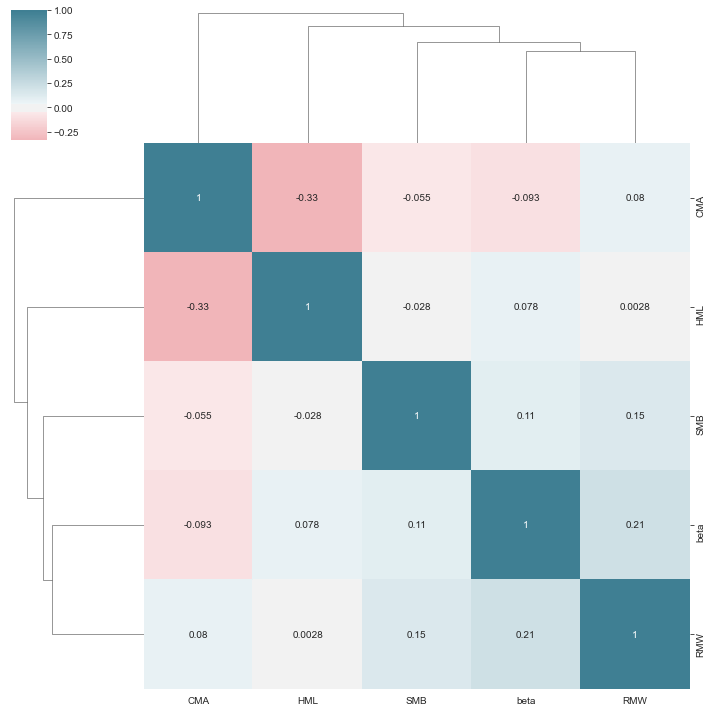

In [52]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [53]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift())
       .dropna()
       .sort_index())

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 57334 entries, ('A', Timestamp('2010-12-31 00:00:00')) to ('ZION', Timestamp('2017-12-31 00:00:00'))
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atr         57334 non-null  float64
 1   bb_down     57334 non-null  float64
 2   bb_high     57334 non-null  float64
 3   bb_low      57334 non-null  float64
 4   bb_mid      57334 non-null  float64
 5   bb_up       57334 non-null  float64
 6   macd        57334 non-null  float64
 7   natr        57334 non-null  float64
 8   rsi         57334 non-null  float64
 9   sector      57334 non-null  object 
 10  return_1m   57334 non-null  float64
 11  return_3m   57334 non-null  float64
 12  return_6m   57334 non-null  float64
 13  return_12m  57334 non-null  float64
 14  beta        57334 non-null  float64
 15  SMB         57334 non-null  float64
 16  HML         57334 non-null  float64
 17  RMW         57334 non-null  floa

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [55]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)    

## Date Indicators

In [56]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [57]:
data['target'] = data.groupby(level='ticker')[f'return_1m'].shift(-1)

In [59]:
data = data.dropna()

In [111]:
data.sort_index().info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 56756 entries, ('A', Timestamp('2010-12-31 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            56756 non-null  float64
 1   bb_down        56756 non-null  float64
 2   bb_high        56756 non-null  float64
 3   bb_low         56756 non-null  float64
 4   bb_mid         56756 non-null  float64
 5   bb_up          56756 non-null  float64
 6   macd           56756 non-null  float64
 7   natr           56756 non-null  float64
 8   rsi            56756 non-null  float64
 9   sector         56756 non-null  object 
 10  return_1m      56756 non-null  float64
 11  return_3m      56756 non-null  float64
 12  return_6m      56756 non-null  float64
 13  return_12m     56756 non-null  float64
 14  beta           56756 non-null  float64
 15  SMB            56756 non-null  float64
 16  HML            5675

## Sector Breakdown

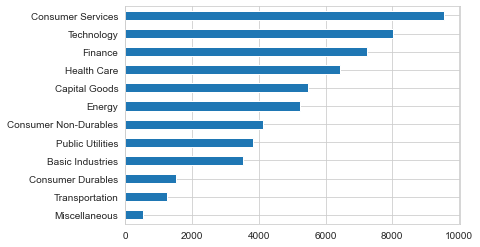

In [98]:
data.sector.value_counts().sort_values().plot.barh();

## Evaluate mutual information

In [60]:
X = pd.get_dummies(data.drop('target', axis=1), prefix='', prefix_sep='')

In [61]:
mi = mutual_info_regression(X=X, y=data.target)

In [62]:
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

natr             0.109572
return_12m       0.062191
return_6m        0.052837
year             0.052613
return_3m        0.049667
momentum_12      0.040819
bb_low           0.040697
momentum_3_6     0.040644
bb_up            0.039776
momentum_3_12    0.038904
dtype: float64

In [63]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [64]:
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

year                 0.010443
month                0.007040
beta                 0.004649
return_6m            0.004020
natr                 0.003493
bb_low               0.002777
Miscellaneous        0.002553
Public Utilities     0.002463
return_12m           0.002170
Consumer Services    0.001975
dtype: float64

In [107]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

In [108]:
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

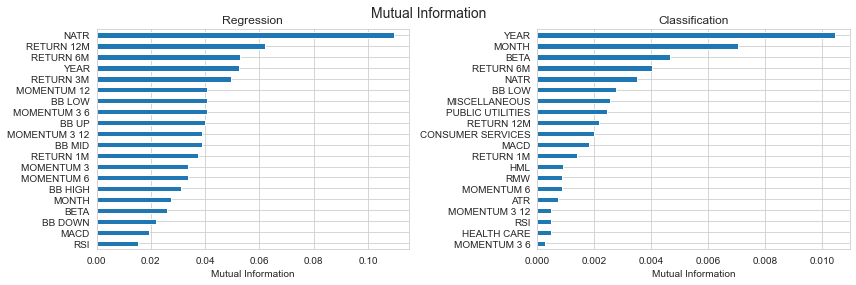

In [109]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('figures/data_mi', dpi=300);

## Store data

In [95]:
with pd.HDFStore('data.h5') as store:
    store.put('us/equities/monthly', data)